In [2]:
import torchdrug

ModuleNotFoundError: No module named 'torchdrug'

In [6]:
# To install torchdrug need to know
import torch
print(torch.__version__)
print(torch.version.cuda)

1.13.0
11.7


In [7]:
# !pip install torch-scatter torch-cluster -f https://pytorch-geometric.com/whl/torch-1.13.0+cu117.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.13.0+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 38.5 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 16.4 MB/s eta 0:00:00a 0:00:01


In [10]:
# !pip install torchdrug

In [11]:
from torchdrug import datasets


SUBCELLULAR_PATH = "/home/ec2-user/esm-data/"

In [12]:
from torchdrug import transforms
from torchdrug import datasets

truncate_transform = transforms.TruncateProtein(max_length=1024, random=False)
protein_view_transform = transforms.ProteinView(view="residue")
transform = transforms.Compose([truncate_transform, protein_view_transform])
dataset = datasets.SubcellularLocalization(SUBCELLULAR_PATH, atom_feature=None, bond_feature=None, residue_feature="default", transform=transform)

23:36:23   Downloading https://miladeepgraphlearningproteindata.s3.us-east-2.amazonaws.com/peerdata/subcellular_localization.tar.gz to /home/ec2-user/esm-data/subcellular_localization.tar.gz
23:36:24   Extracting /home/ec2-user/esm-data/subcellular_localization.tar.gz to /home/ec2-user/esm-data


Constructing proteins from sequences:  10%|█         | 1421/14004 [00:02<00:29, 428.90it/s]/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchdrug/data/protein.py:264: UserWarning: Unknown residue symbol `U`. Treat as glycine
  warnings.warn("Unknown residue symbol `%s`. Treat as glycine" % residue)
Constructing proteins from sequences:  47%|████▋     | 6640/14004 [00:12<00:18, 396.63it/s]/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchdrug/data/protein.py:264: UserWarning: Unknown residue symbol `X`. Treat as glycine
  warnings.warn("Unknown residue symbol `%s`. Treat as glycine" % residue)
Constructing proteins from sequences:  57%|█████▋    | 7914/14004 [00:14<00:07, 799.49it/s]/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchdrug/data/protein.py:264: UserWarning: Unknown residue symbol `B`. Treat as glycine
  warnings.warn("Unknown residue symbol `%s`. Treat as glycine" % residue)
Constructing proteins from sequences:  96%|█████████▋| 13503/14004 [00:24<00:00

In [13]:
dataset[0]

{'graph': Protein(num_atom=0, num_bond=0, num_residue=484), 'localization': 0}

In [14]:
train_set, valid_set, test_set = dataset.split()

In [15]:
print("The label of first sample: ", dataset[0][dataset.target_fields[0]])
print("train samples: %d, valid samples: %d, test samples: %d" % (len(train_set), len(valid_set), len(test_set)))

The label of first sample:  0
train samples: 8420, valid samples: 2811, test samples: 2773


In [16]:
prot_seq = dataset[0]['graph'].to_sequence().replace('.', '')

In [24]:
import pandas as pd
from tqdm import tqdm

seq = []
for item in tqdm(train_set):
    aa = item['graph'].to_sequence().replace('.', '')
    loc = item['localization']
    seq.append({'Peptide': aa, 'loc': loc, 'split': 'train'})

for item in tqdm(valid_set):
    aa = item['graph'].to_sequence().replace('.', '')
    loc = item['localization']
    seq.append({'Peptide': aa, 'loc': loc, 'split': 'val'})

for item in tqdm(test_set):
    aa = item['graph'].to_sequence().replace('.', '')
    loc = item['localization']
    seq.append({'Peptide': aa, 'loc': loc, 'split': 'test'})

seq = pd.DataFrame(seq)

100%|██████████| 2773/2773 [00:01<00:00, 1607.89it/s]


In [25]:
import os

protein_loc_path = os.path.join(SUBCELLULAR_PATH, 'protein_loc.csv')

In [26]:
seq.to_csv(protein_loc_path)

In [27]:
seq.index

RangeIndex(start=0, stop=14004, step=1)

## Load embeddings and train localization model

In [32]:
import pandas as pd
import zarr
import os
import numpy as np


protein_loc_path = os.path.join(SUBCELLULAR_PATH, 'protein_loc.csv')
protein_embed_path = os.path.join(SUBCELLULAR_PATH, 'esm2_t33_650M_UR50D.zarr')

seq = pd.read_csv(protein_loc_path)
embed = np.asarray(zarr.open(protein_embed_path))

In [48]:
seq["Length"] = (
    seq["Peptide"].apply(lambda x: len(x.replace("*", "")))
)

In [43]:
sequences

0        484
1        609
2        334
3        128
4        657
        ... 
13999     67
14000     66
14001    415
14002    183
14003    146
Name: Peptide, Length: 14004, dtype: int64

In [29]:
print(len(seq))

14004


In [33]:
print(embed.shape)

(14004, 1025, 1280)


In [51]:
mean_embed = np.sum(embed[:, 1:], axis=1) / seq["Length"].values[:, None]

In [52]:
print(mean_embed.shape)

(14004, 1280)


In [55]:
from sklearn.linear_model import LogisticRegression


index = (seq['split'] == 'train').values
X_train = mean_embed[index]
y_train = seq[index]['loc']

index = (seq['split'] == 'val').values
X_val = mean_embed[index]
y_val = seq[index]['loc']

index = (seq['split'] == 'test').values
X_test = mean_embed[index]
y_test = seq[index]['loc']

In [56]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [57]:
y_predict = clf.predict(X_test)

In [58]:
from sklearn.metrics import confusion_matrix, accuracy_score

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict)

Accuracy 0.7962495492246664


In [61]:
%matplotlib inline

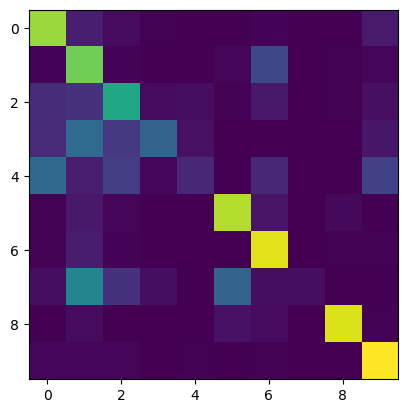

In [62]:
import matplotlib.pyplot as plt

plt.imshow(cm / cm.sum(axis=1)[:, None])

## Images